In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark
%watermark -v -n -m -p numpy,scipy,sklearn,pandas

Sat Mar 30 2019 

CPython 3.6.6
IPython 6.5.0

numpy 1.15.1
scipy 1.1.0
sklearn 0.19.1
pandas 0.23.4

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.20.5-arch1-1-ARCH
machine    : x86_64
processor  : 
CPU cores  : 12
interpreter: 64bit


In [2]:
%matplotlib inline
# %matplotlib notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import nolds
import data
import mne

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_ROOT = os.path.abspath(os.path.join(PROJ_ROOT, 'data'))
PROCESSED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'processed'))
RAW_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'raw'))
LABELED_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'labeled'))
DURATIONS_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'durations'))
VISUAL_ROOT = os.path.abspath(os.path.join(DATA_ROOT, 'visual'))
import sys
sys.path.append(os.path.join(PROJ_ROOT, 'src'))
CHANNEL_NAMES = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz']
META_COLUMN_NAMES = ['freq', 'RESP_4W', 'RESP_FIN', 'REMISE_FIN', 'AGE', 'SEX', 'M_1',
       'M_4', 'M_F', 'délka léčby', 'lék 1', 'lék 2', 'lék 3', 'lék 4']
EXTRA = ['age', 'sex', 'sc_bef', 'sc_aft']
META_FILE_NAME = 'DEP-POOL_Final_144.xlsx'
meta_df = pd.read_excel(os.path.join(RAW_ROOT, META_FILE_NAME), index_col='ID', names=META_COLUMN_NAMES)

raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))
t = pd.DataFrame(raw_fif.get_data())
data = pd.DataFrame(np.transpose(t.values), columns=CHANNEL_NAMES)
data = np.transpose(data.values)
metapkl = pd.read_pickle(os.path.join(LABELED_ROOT, 'processed', 'meta', 'meta.pkl'))

Opening raw data file /home/kovar/thesis_project/data/processed/1a.fif...
This filename (/home/kovar/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
Isotrak not found
    Range : 0 ... 19104 =      0.000 ...    76.416 secs
Ready.


<ipython-input-2-0beabae29118>:29: RuntimeWarning: This filename (/home/kovar/thesis_project/data/processed/1a.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz or raw_tsss.fif.gz
  raw_fif = mne.io.read_raw_fif(os.path.join(PROCESSED_ROOT, '1a.fif'))


In [3]:
meta_df['SEX'] = meta_df['SEX'].astype('category')
print("Women: %s " % len(meta_df['SEX'][meta_df['SEX']==0]))
print("Men: %s " % len(meta_df['SEX'][meta_df['SEX']==1]))
print("Age: \n%s" % meta_df['AGE'].describe())
print('250 Hz: %s \t 1000 Hz: %s' % (len(meta_df[meta_df['freq']==250]),len(meta_df[meta_df['freq']==1000])))

Women: 104 
Men: 29 
Age: 
count    133.000000
mean      47.706767
std        9.577263
min       30.000000
25%       39.000000
50%       49.000000
75%       55.000000
max       65.000000
Name: AGE, dtype: float64
250 Hz: 99 	 1000 Hz: 34


In [4]:
def f(row, col):
    if row[col] <= 16:
        return -1
    if row[col] <= 28:
        return 0
    else:
        return 1
def ff(row, col, n=5):
    for i in range(n):
        if row[col] <= metapkl.quantile((i+1)/n)[col]:
            return i
    
metapkl['dep'] = metapkl.apply(lambda row: f(row, 'sc'), axis=1)
metapkl['dep_bef'] = metapkl.apply(lambda row: f(row, 'sc_bef'), axis=1)
metapkl['dep_aft'] = metapkl.apply(lambda row: f(row, 'sc_aft'), axis=1)
metapkl = metapkl.astype({'dep': 'category', 'dep_bef': 'category', 'dep_aft': 'category'})                                           
print(metapkl['dep'].value_counts())
print(metapkl['dep_bef'].value_counts())
print(metapkl['dep_aft'].value_counts())

def f(row, col):
    if row[col] <= metapkl.loc[(slice(None), 'a'), :].quantile(0.42)['change']:
        return -1
    if row[col] <= metapkl.loc[(slice(None), 'a'), :].quantile(0.56)['change']:
        return 0
    else:
        return 1
    
metapkl['resp'] = metapkl.apply(lambda row: f(row, 'change'), axis=1)
metapkl = metapkl.astype({'resp': 'category'})                                           
print(metapkl.loc[(slice(None), 'a'), 'resp'].value_counts())

 0    148
-1     62
 1     56
Name: dep, dtype: int64
0    170
1     96
Name: dep_bef, dtype: int64
 0    126
-1    124
 1     16
Name: dep_aft, dtype: int64
 1    59
-1    57
 0    17
Name: resp, dtype: int64


In [130]:
def prepare_dfs(col='lyap', kind='processed'):
    df = pd.read_pickle(os.path.join(LABELED_ROOT, kind, col, f'training_{col}.pkl')) 
    df_bef = pd.read_pickle(os.path.join(LABELED_ROOT, kind, col, f'{col}_bef.pkl'))
    df_aft = pd.read_pickle(os.path.join(LABELED_ROOT, kind, col, f'{col}_aft.pkl'))
    df.columns = df.columns.droplevel(1)
    df_aft.columns = df_aft.columns.droplevel(1)
    return df, df.loc[(slice(None),'a'),:], df.loc[(slice(None), 'b'), :]
    
def prepare_resp_non(col='lyap'):
    df, df_bef, df_aft = prepare_dfs(col)
    df = df.join(metapkl)
    df_resp = df[df['resp']==1]
    df_non = df[df['resp']==-1]
    # df_resp.columns = df_resp.columns.droplevel(0)
    # df_non.columns = df_non.columns.droplevel(0)
    return df_resp, df_non

def prepare_dep_nond(col='lyap'):
    df, df_bef, df_aft = prepare_dfs(col)
    df = df.join(metapkl)
    df_dep = df[df['dep']==1]
    df_nond = df[df['dep']==-1]
    # l = max(len(df_dep), len(df_nond))
    # df_resp.columns = df_resp.columns.droplevel(0)
    # df_non.columns = df_non.columns.droplevel(0)
    return df_dep, df_nond

df, df_bef, df_aft = prepare_dfs('lyap')
df_resp, df_non = prepare_resp_non('lyap')
df_dep, df_nond = prepare_dep_nond('lyap')

In [133]:
df_bef

,channel,FP1,FP2,F3,F4,C3,C4,P3,P4,O1,O2,F7,F8,T3,T4,T5,T6,Fz,Cz,Pz
patient,trial,,,,,,,,,,,,,,,,,,,
1,a,10.029887,11.703816,9.214353,9.940690,9.454637,8.968706,10.291312,10.699735,10.694263,10.830928,11.706014,11.319699,10.983517,10.112448,10.786911,10.200675,11.438303,10.398645,10.864746
3,a,11.491857,11.446344,11.668608,11.491566,11.875358,11.635701,11.637798,12.151068,12.020648,12.245213,11.701191,11.463553,11.660495,11.443803,11.981148,12.389654,11.696664,11.161615,11.693635
4,a,11.049518,11.246144,10.800703,11.212004,10.770177,10.915308,11.639975,11.642685,12.457973,12.388291,10.985918,11.545668,10.338510,11.962579,11.912929,12.570024,11.053828,11.087049,11.298188
5,a,10.608832,10.429371,9.958579,9.779142,9.767949,10.485648,10.150168,10.719995,10.941863,10.896158,10.567988,10.814277,10.513613,10.639456,10.556927,11.343273,10.318414,9.715487,10.902905
7,a,10.569585,10.164602,10.603027,10.453541,10.934872,10.852852,11.089520,11.250564,11.168932,11.034406,10.787532,11.404740,11.248912,11.207786,11.455900,11.154911,10.601929,10.514550,10.925728
9,a,10.462948,10.407645,10.633778,10.445797,10.052567,10.279399,10.808690,10.666443,10.850050,11.176296,11.202457,10.919765,10.595331,11.279022,10.700312,11.179679,10.237445,10.222082,10.726023
10,a,8.464631,8.587235,8.304111,8.648945,8.438431,9.846842,10.021834,10.327355,10.699308,10.129354,7.827855,9.210105,8.808807,8.999207,10.300150,9.846341,9.728831,9.855809,9.991290
11,a,9.938870,10.700517,9.982946,10.238261,10.231401,10.485788,11.065944,11.056899,10.595254,11.061671,8.523782,8.024192,8.268766,8.398938,10.633143,11.311106,10.596064,10.245863,11.057297
12,a,10.559718,8.606021,8.862489,9.546337,9.779549,9.159371,10.776080,10.356051,10.778008,10.493210,7.821712,9.149140,9.991514,7.932659,10.354828,10.706383,10.274372,10.576414,10.761428


[]

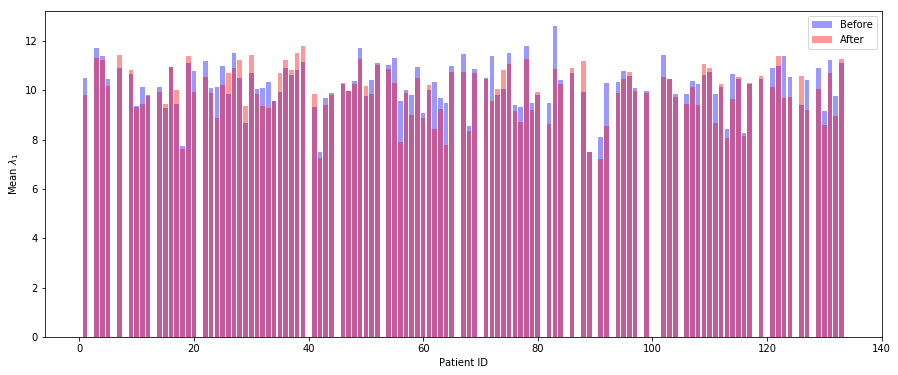

In [80]:
df, df_bef, df_aft = prepare_dfs('lyap')
df_bef.index = df_bef.index.droplevel(1)
df_aft.index = df_aft.index.droplevel(1)

joined = df_bef.join(df_aft, lsuffix='a', rsuffix='b')
filter_col_a = [col for col in joined.columns if col.endswith('a')]
means_bef = joined[filter_col_a].mean(1)
filter_col_b = [col for col in joined.columns if col.endswith('b')]
means_aft = joined[filter_col_b].mean(1)
diffs = np.abs(means_bef-means_aft)

bar_width = 0.8
opacity = 0.4
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.bar(means_bef.index, means_bef, bar_width, label='Before', alpha=opacity, color='b')
ax.bar(means_aft.index, means_aft, bar_width, label='After', alpha=opacity, color='r')
# ax.set_ylim([7.0, 13])
# ax.set_xlim([0, 134])
ax.set_xlabel('Patient ID')
ax.set_ylabel(rf'Mean $\lambda_1$')
ax.legend()
plt.plot()

[]

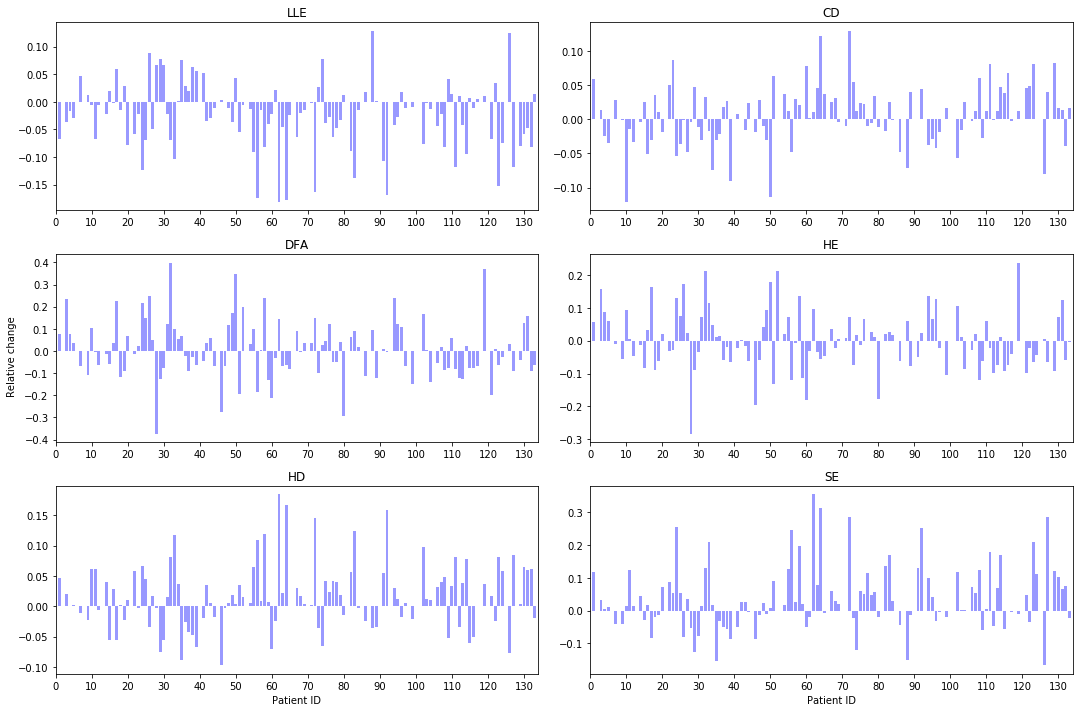

In [137]:
bar_width = 0.8
opacity = 0.4
fig, ax = plt.subplots(3, 2, figsize=(15,10), sharey=False, sharex=False)
col_to_name = {
    'lyap': 'LLE',
    'corr': 'CD',
    'dfa': 'DFA',
    'sampen': 'SE',
    'higu': 'HD',
    'hurst': 'HE',
}
for axs, (i, col) in zip(ax.reshape(-1), enumerate(['lyap', 'corr', 'dfa', 'hurst', 'higu', 'sampen'])):
    df, df_bef, df_aft = prepare_dfs(col)
    df_bef.index = df_bef.index.droplevel(1)
    df_aft.index = df_aft.index.droplevel(1)
    joined = df_bef.join(df_aft, lsuffix='a', rsuffix='b')
    filter_col_a = [col for col in joined.columns if col.endswith('a')]
    means_bef = joined[filter_col_a].mean(1)
    filter_col_b = [col for col in joined.columns if col.endswith('b')]
    means_aft = joined[filter_col_b].mean(1)
    axs.set_title(col_to_name[col])
    axs.set_xlim((0,134))
    axs.xaxis.set_ticks(np.arange(0, 133, 10))
    axs.bar(means_bef.index, (means_aft-means_bef)/np.abs(means_bef), bar_width, label='col', alpha=opacity, color='b')
ax[2, 0].set_xlabel('Patient ID')
ax[2, 1].set_xlabel('Patient ID')
fig.tight_layout()
fig.text(0, 0.5, 'Relative change', va='center', rotation='vertical')
fig.savefig('/home/kovar/rel_change.png')
plt.plot()

# Before and after comparison plots

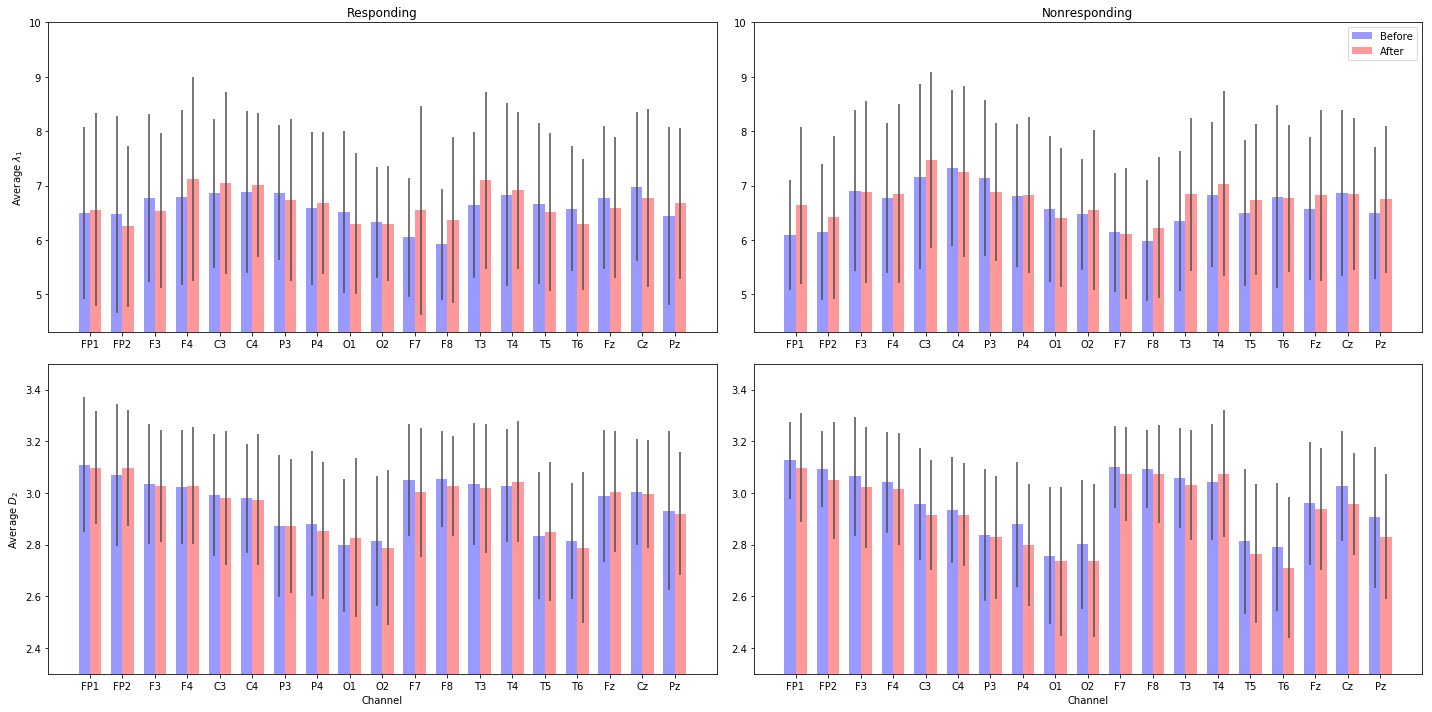

In [37]:
def plot_bars(dfa, dfb, ax):
    bar_width = 0.35

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    index = np.arange(len(CHANNEL_NAMES))
    
    dfa = dfa[CHANNEL_NAMES]
    dfb = dfb[CHANNEL_NAMES]

    meansa = dfa.mean()
    meansb = dfb.mean()
    stda = dfa.std()
    stdb = dfb.std()

    rects1 = ax.bar(index, meansa, bar_width,
                    alpha=opacity, color='b',
                    yerr=stda, error_kw=error_config,
                    label='Before')

    rects2 = ax.bar(index + bar_width, meansb, bar_width,
                    alpha=opacity, color='r',
                    yerr=stdb, error_kw=error_config,
                    label='After')
    
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(CHANNEL_NAMES)
    
col_to_ylim = {
    # 'lyap': (7.5, 13), # 10 3
    'lyap': (4.3, 10), # auto
    # 'corr': (6.5, 9), # 10 3
    # 'corr': (8.5, 13),
    'corr': (2.3, 3.5), # auto
    'dfa':    (0.18, 1),
    'sampen': (0.5, 1.2),
}

col_to_name = {
    'lyap': '$\lambda_1$',
    'corr': '$D_2$',
    'dfa': 'DFA',
    'sampen': 'sample entropy',
}

fig, ax = plt.subplots(2, 2, figsize=(20,10), sharex=False, sharey=False)

col = 'lyap'
df, df_bef, df_aft = prepare_dfs(col)
df_resp, df_non = prepare_resp_non(col)

plot_bars(df_resp.loc[(slice(None), 'a'), :], df_resp.loc[(slice(None), 'b'), :], ax[0,0])

ax[0, 0].set_title('Responding')
ax[0, 0].set_ylabel(r'Average {}'.format(col_to_name[col]))
ax[0, 0].set_ylim(col_to_ylim[col])

plot_bars(df_non.loc[(slice(None), 'a'), :], df_non.loc[(slice(None), 'b'), :], ax[0,1])

ax[0, 1].set_title('Nonresponding')
ax[0, 1].set_ylim(col_to_ylim[col])
ax[0, 1].legend()

col = 'corr'
df, df_bef, df_aft = prepare_dfs(col)
df_resp, df_non = prepare_resp_non(col)

plot_bars(df_resp.loc[(slice(None), 'a'), :], df_resp.loc[(slice(None), 'b'), :], ax[1,0])

ax[1, 0].set_xlabel('Channel')
ax[1, 0].set_ylabel(r'Average {}'.format(col_to_name[col]))
ax[1, 0].set_ylim(col_to_ylim[col])

plot_bars(df_non.loc[(slice(None), 'a'), :], df_non.loc[(slice(None), 'b'), :], ax[1,1])

ax[1, 1].set_xlabel('Channel')
ax[1, 1].set_ylim(col_to_ylim[col])

fig.tight_layout()
# fig.savefig('/home/miroslav/Documents/DP/Images/bars/resp_non2.png')
fig.savefig('/home/kovar/resp_non1_auto.png')
plt.show()

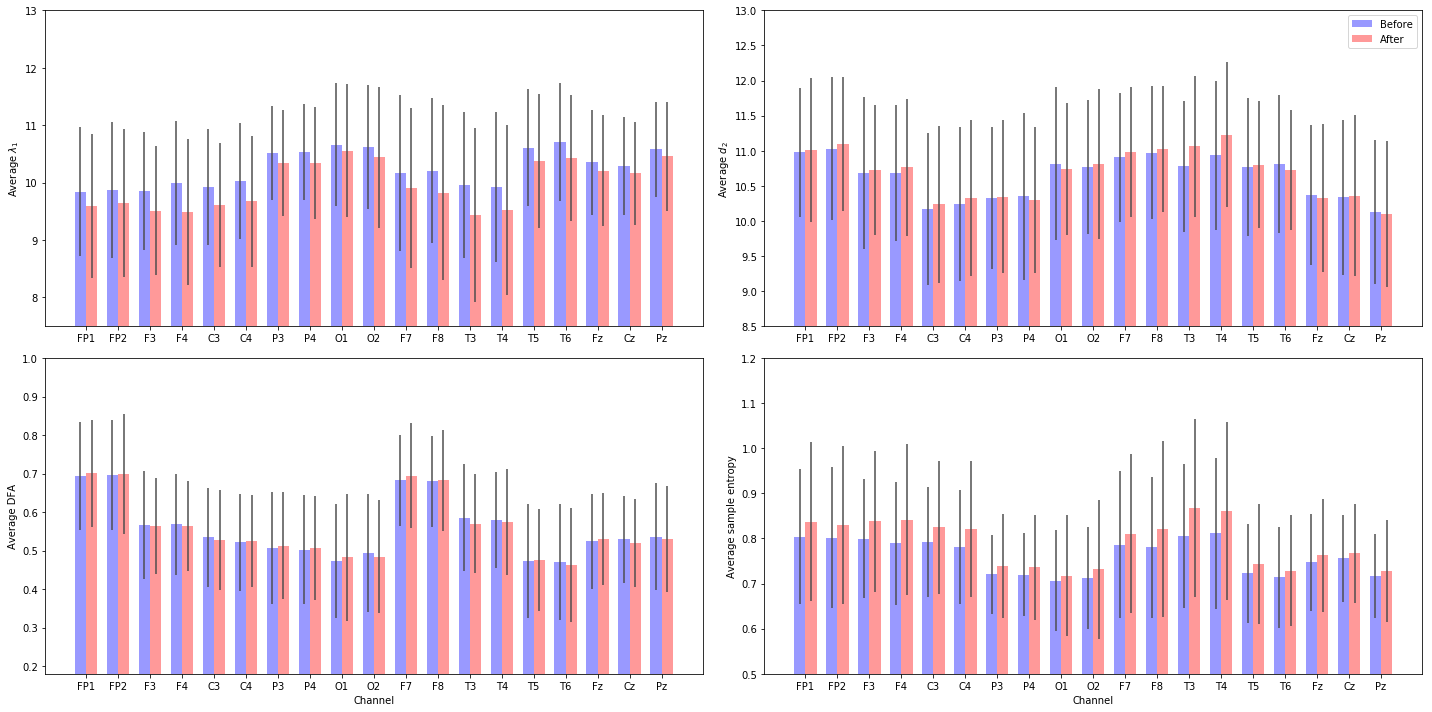

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(20,10), sharex=False, sharey=False)

col = 'lyap'
df, df_bef, df_aft = prepare_dfs(col)

plot_bars(df_bef, df_aft, ax[0,0])

# ax[0, 0].set_title('Responding')
ax[0, 0].set_ylabel(r'Average {}'.format(col_to_name[col]))
ax[0, 0].set_ylim(col_to_ylim[col])

col = 'corr'
df, df_bef, df_aft = prepare_dfs(col)

plot_bars(df_bef, df_aft, ax[0,1])

# ax[0, 1].set_title('Non-responding')
ax[0, 1].set_ylabel(r'Average {}'.format(col_to_name[col]))
ax[0, 1].set_ylim(col_to_ylim[col])
ax[0, 1].legend()

col = 'dfa'
df, df_bef, df_aft = prepare_dfs(col)

plot_bars(df_bef, df_aft, ax[1,0])

ax[1, 0].set_xlabel('Channel')
ax[1, 0].set_ylabel(r'Average {}'.format(col_to_name[col]))
ax[1, 0].set_ylim(col_to_ylim[col])

col = 'sampen'
df, df_bef, df_aft = prepare_dfs(col)

plot_bars(df_bef, df_aft, ax[1,1])

ax[1, 1].set_xlabel('Channel')
ax[1, 1].set_ylabel(r'Average {}'.format(col_to_name[col]))
ax[1, 1].set_ylim(col_to_ylim[col])

fig.tight_layout()
# fig.savefig('/home/miroslav/Documents/DP/Images/bars/bef_aft.png')
fig.savefig('/home/kovar/bef_aft.png')
plt.show()

# Before and after K-S test

In [135]:
from scipy.stats import ks_2samp, kruskal
from codecs import decode

def print_res(name, res, mean1=0, mean2=0, std1=0, std2=0):
    if res.pvalue <= 0.01:
        m = '***'
    elif res.pvalue <= 0.02:
        m = '**'
    elif res.pvalue <= 0.05:
        m = '*'
    else:
        m = ''
    s = '{: <8} & {: <5.3f} $\pm$ {:<5.3f} & {: <5.3f} $\pm$ {: <5.3f} & {: <5.3f} & {: <5} \\\\ \hline'
    print(s.format(name, mean1, std1,  mean2, std2, res.pvalue, m))

def channel_wise_ks(df_bef, df_aft, test=kruskal):
    dfa = df_bef[CHANNEL_NAMES].mean(axis=1)
    dfb = df_aft[CHANNEL_NAMES].mean(axis=1)
    print_res('mean', test(dfa, dfb), dfa.mean(), dfb.mean(), dfa.std(), dfb.std())
    dfa = df_bef[CHANNEL_NAMES].std(axis=1)
    dfb = df_aft[CHANNEL_NAMES].std(axis=1)
    print_res('std', test(dfa, dfb), dfa.mean(), dfb.mean(), dfa.std(), dfb.std())
    for col in CHANNEL_NAMES:
        print_res(col, test(df_bef[col], df_aft[col]), df_bef[col].mean(), df_aft[col].mean(), df_bef[col].std(), df_aft[col].std())
        

for col in ['lyap', 'corr', 'sampen', 'dfa', 'higu', 'hurst']:
    df, df_bef, df_aft = prepare_dfs(col)
    df_resp, df_non = prepare_resp_non(col)
    print('\n\n\n' + col.upper())
    print('All before/after treatment: {} / {}'.format(len(df_bef), len(df_aft)))
    channel_wise_ks(df_bef, df_aft)
    # print('\nResponding before/after treatment: {} / {}'.format(len(df_resp.loc[(slice(None), 'a'), :]), len(df_resp.loc[(slice(None), 'b'), :])))
    # channel_wise_ks(df_resp.loc[(slice(None), 'a'), :] , df_resp.loc[(slice(None), 'b'), :])
    # print('\nNon-responding before/after treatment: {} / {}'.format(len(df_non.loc[(slice(None), 'a'), :]), len(df_non.loc[(slice(None), 'b'), :])))
    # channel_wise_ks(df_non.loc[(slice(None), 'a'), :] , df_non.loc[(slice(None), 'b'), :])
    # print('\nResponding/Nonresponding all: {} / {}'.format(len(df_resp), len(df_non)))
    # channel_wise_ks(df_resp, df_non)
    # print('\nResponding/Nonresponding before treatment: {} / {}'.format(len(df_resp.loc[(slice(None), 'a'), :]), len(df_non.loc[(slice(None), 'a'), :])))
    # channel_wise_ks(df_resp.loc[(slice(None), 'a'), :] , df_non.loc[(slice(None), 'a'), :])
    # print('\nResponding/Nonresponding after treatment: {} / {}'.format(len(df_resp.loc[(slice(None), 'b'), :]), len(df_non.loc[(slice(None), 'b'), :])))
    # channel_wise_ks(df_resp.loc[(slice(None), 'b'), :] , df_non.loc[(slice(None), 'b'), :])

# print('*** LOW / HIGH DEPRESSION SCORE ***')
# for col in ['lyap', 'corr', 'sampen', 'dfa', 'hurst', 'sampen', 'higu']:
# # for col in ['corr',]:
#     df_dep, df_nond = prepare_dep_nond(col)
#     print(col.upper())
#     channel_wise_ks(df_nond, df_dep)
#     
# print('*** RESPONDING / NON-RESPONDING - terciles ***')
# for col in ['lyap', 'corr', 'sampen', 'dfa']:
#     df_resp, df_non = prepare_resp_non(col)
#     print(col.upper())
#     print(len(df_resp.loc[(slice(None), 'a'), :]))
#     print(len(df_non.loc[(slice(None), 'a'), :]))
#     print(len(df_resp.loc[(slice(None), 'b'), :]))
#     print(len(df_non.loc[(slice(None), 'b'), :]))
#     print('resp/nonresp before treatment')
#     channel_wise_ks(df_resp.loc[(slice(None), 'a'), :] , df_non.loc[(slice(None), 'a'), :])
#     print('resp/nonresp after treatment')
#     channel_wise_ks(df_resp.loc[(slice(None), 'b'), :] , df_non.loc[(slice(None), 'b'), :])




LYAP
All before/after treatment: 110 / 110
mean     & 10.245 $\pm$ 0.906 & 9.976 $\pm$ 1.015 & 0.064 &       \\ \hline
std      & 0.617 $\pm$ 0.239 & 0.703 $\pm$ 0.303 & 0.047 & *     \\ \hline
FP1      & 9.845 $\pm$ 1.129 & 9.593 $\pm$ 1.258 & 0.181 &       \\ \hline
FP2      & 9.877 $\pm$ 1.184 & 9.645 $\pm$ 1.291 & 0.223 &       \\ \hline
F3       & 9.853 $\pm$ 1.021 & 9.509 $\pm$ 1.124 & 0.042 & *     \\ \hline
F4       & 9.994 $\pm$ 1.082 & 9.491 $\pm$ 1.272 & 0.004 & ***   \\ \hline
C3       & 9.931 $\pm$ 1.010 & 9.612 $\pm$ 1.080 & 0.032 & *     \\ \hline
C4       & 10.027 $\pm$ 1.017 & 9.675 $\pm$ 1.142 & 0.019 & **    \\ \hline
P3       & 10.516 $\pm$ 0.816 & 10.343 $\pm$ 0.931 & 0.262 &       \\ \hline
P4       & 10.536 $\pm$ 0.835 & 10.336 $\pm$ 0.975 & 0.257 &       \\ \hline
O1       & 10.664 $\pm$ 1.067 & 10.557 $\pm$ 1.164 & 0.576 &       \\ \hline
O2       & 10.617 $\pm$ 1.076 & 10.438 $\pm$ 1.231 & 0.266 &       \\ \hline
F7       & 10.164 $\pm$ 1.361 & 9.908 $\pm$ 

# PCA

No handles with labels found to put in legend.


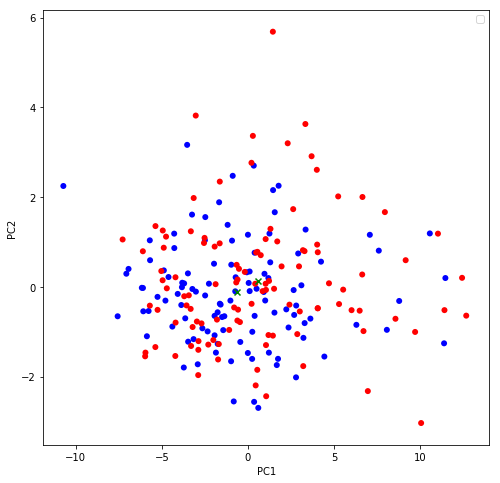

No handles with labels found to put in legend.


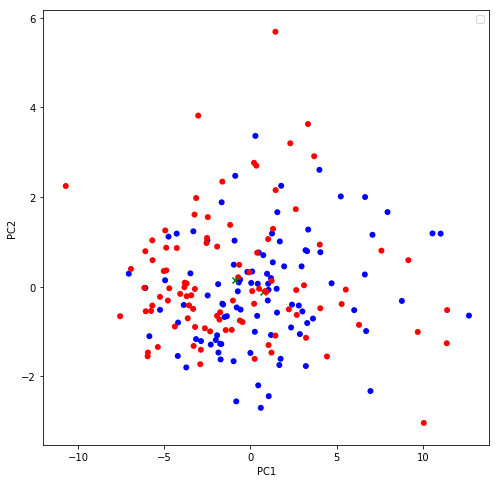

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets

def normalize(df):
    return (df - df.min()) / (df.max() - df.min())

def plot_pca_2d(df_first, df_second=None, c1='blue', c2='red', title=""):
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    fig = plt.figure(figsize=(8,8))
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.scatter(first[:,0], first[:,1], c=c1, cmap='Blues', edgecolors='', label='')
    plt.scatter(np.average(first[:,0]), np.average(first[:,1]), c='g', marker='x')
    if second is not None:
        plt.scatter(second[:,0], second[:,1], c=c2, cmap='Reds', edgecolors='', label='')
        plt.scatter(np.average(second[:,0]), np.average(second[:,1]), c='g', marker='x')
    # plt.title(title)
    plt.legend()
    # plt.colorbar()
    plt.show()

col = 'lyap'
df, df_bef, df_aft = prepare_dfs(col)
df_resp, df_non = prepare_resp_non(col)
pca = decomposition.PCA(n_components=2)
pca.fit(df[CHANNEL_NAMES])

plot_pca_2d(df_bef, df_aft, title="Before / After")
# plot_pca_2d(df, None, c1=df['change'], title="Change in score")
# plot_pca_2d(df_bef, None, c1=df_bef['sc_bef'], title="")
# plot_pca_2d(df_aft, None, c1=df_aft['sc_aft'], title="")
# plot_pca_2d(df_aft[df_aft['sc_aft'] > 27], c1='red', title="")
# plot_pca_2d(df_bef[df_bef['sc_bef'] > 30], title="")
# plot_pca_2d(df[(df['sc']>30) & (df['sc']>30)], df[(df['sc'] < 20) & (df['sc'] < 20)], title="Depressed / Non-depressed")
# plot_pca_2d(df[df['sc'] <= 10], df[df['sc'] >= 30], title='Depressed / Not Depressed')
plot_pca_2d(df_resp, df_non, title='Resp / Non')

<IPython.core.display.Javascript object>


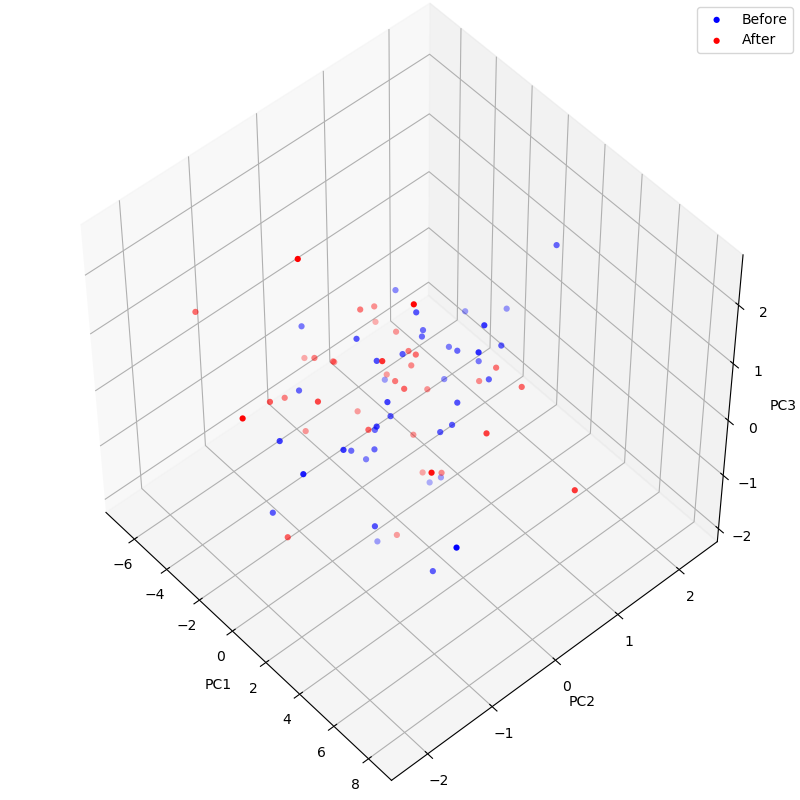

In [249]:
def plot_pca_3d(df_first, df_second=None, c1='blue', c2='red', title="", clus=False):
    pca = decomposition.PCA(n_components=3)
    pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    fig = plt.figure(figsize=(8,8))
    ax = Axes3D(fig)
    if clus:
        clus_bef = df_first.iloc[(-4 < first[:,0]) & (first[:,0] < -2) & (first[:,1] < 1) & (0 < first[:,1]) & (abs(first[:,2]) < 1), :][EXTRA]
        clus_aft = df_second.iloc[(-4 < second[:,0]) & (second[:,0] < -2) & (second[:,1] < 1) & (0 < second[:,1]) & (abs(second[:,2]) < 1), :][EXTRA]
        overlap = clus_bef.join(clus_aft, how='inner', lsuffix='', rsuffix='_a')
        print(clus_bef)
        print(clus_aft)
        print(overlap.loc[:, ['age', 'sex', 'sc_bef', 'sc_aft']])
        
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.scatter(first[:,0], first[:,1], first[:,2], c=c1, cmap='Blues', edgecolor='', label='Before')
    if second is not None:
        ax.scatter(second[:,0], second[:,1], second[:,2], c=c2, cmap='Reds', edgecolor='', label='After')
    # plt.title(title)
    plt.legend()
    plt.show()

col = 'lyap'
df, df_bef, df_aft = prepare_dfs(col)
df_resp, df_non = prepare_resp_non(col)

# plot_pca_3d(df_bef, df_aft, df_bef['age'], df_aft['age'])
# plot_pca_3d(df_bef, df_aft, title="Before / After")
# plot_pca_3d(df[df['sex']==0], df[df['sex']==1], title="Men / Women") # Men corr cluster
# plot_pca_3d(df_bef, df_aft, df_bef['sc_bef'], df_aft['sc_aft'], title="Scores bef / aft")
plot_pca_3d(df_resp.loc[(slice(None), 'a'), :], df_non.loc[(slice(None), 'a'), :], title='Resp / Non')

<IPython.core.display.Javascript object>


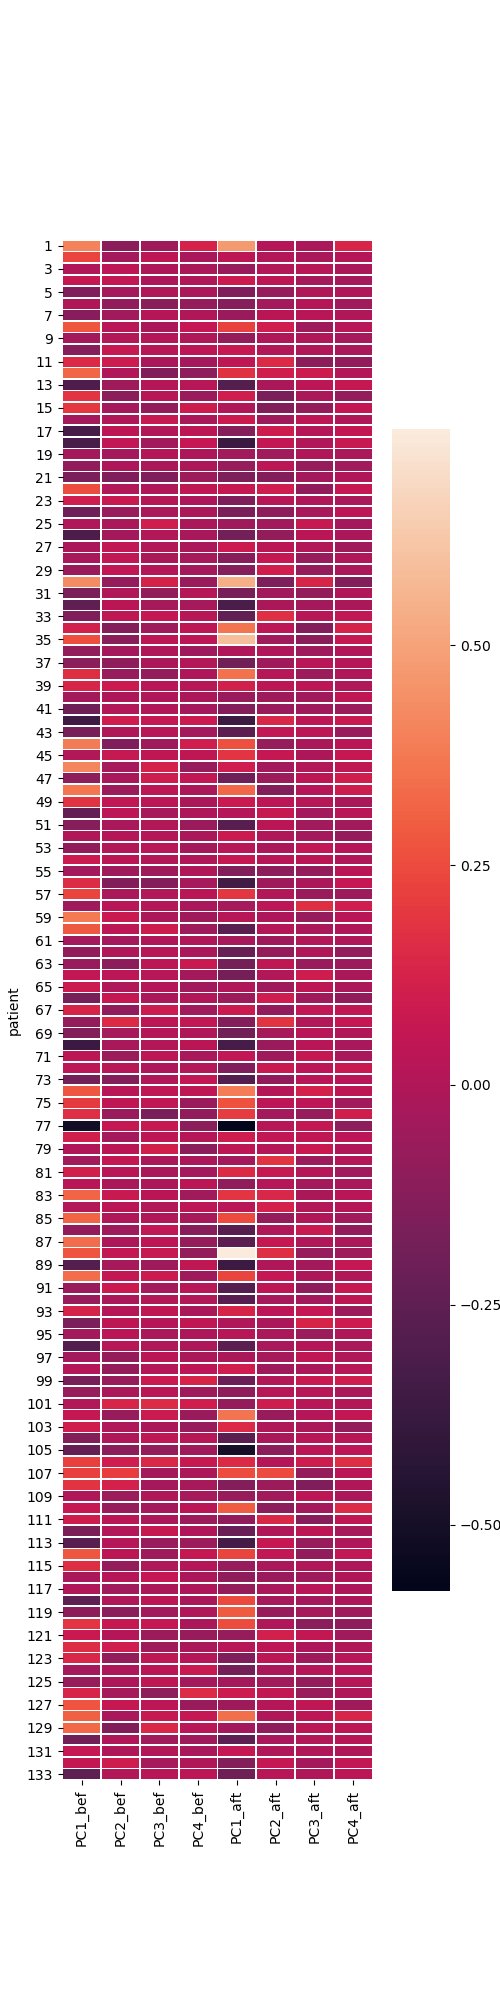

In [93]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

def plot_heatmap(df_bef=df_bef, df_aft=df_aft, n=3, title='All'):

    pca = decomposition.PCA(n_components=4)
    pca.fit(df[CHANNEL_NAMES])
    bef_proj_df = pd.DataFrame(pca.transform(df_bef[CHANNEL_NAMES]), index=df_bef.index, columns=['PC1', 'PC2', 'PC3', 'PC4'])
    aft_proj_df = pd.DataFrame(pca.transform(df_aft[CHANNEL_NAMES]), index=df_aft.index, columns=['PC1', 'PC2', 'PC3', 'PC4'])

    joined_df = bef_proj_df.join(aft_proj_df, lsuffix='_bef', rsuffix='_aft')

    plt.figure(figsize=(5, 20))
    ax = sns.heatmap(joined_df, linewidth=0.5)
    # plt.title(": ".join((measure, title)))
    plt.show()
    # plt.savefig(os.path.join(VISUAL_ROOT, "heatmaps", _".join((measure, title))+'.png'))

# for measure in ('lyap', 'corr', 'sampen'):
for measure in ('higu',):
    df, df_bef, df_aft = prepare_dfs(measure)
    plot_heatmap()
    # plot_heatmap(df_bef[df_bef['sex']==0], df_aft[df_aft['sex']==0], title='Women')
    # plot_heatmap(df_bef[df_bef['sex']==1], df_aft[df_aft['sex']==1], title='Men')
    # plot_heatmap(df_bef[df_bef['age']>50], df_aft[df_aft['age']>50], title='Age >= 50')
    # plot_heatmap(df_bef[df_bef['age']<=30], df_aft[df_aft['age']<=30], title='Age <= 30')
    # plot_heatmap(df_bef[df_bef['label_r']==1], df_aft[df_aft['label_r']==1], title='Responding')
    # plot_heatmap(df_bef[df_bef['label_r']==0], df_aft[df_aft['label_r']==0], title='Non-responding')
    # plot_heatmap(df_bef[df_bef['sc_bef']<25], df_aft[df_aft['sc_bef']<25], title='Score before < 25')
    # plot_heatmap(df_bef[df_bef['sc_bef']>=30], df_aft[df_aft['sc_bef']>=30], title='Score before >= 25')
    # plot_heatmap(df_aft[df_aft['sc_aft']<25], df_aft[df_aft['sc_aft']<25], title='Score after < 25')
    # plot_heatmap(df_aft[df_aft['sc_aft']>=30], df_aft[df_aft['sc_aft']>=30], title='Score after >= 25')
    

# Other ideas

MEAN DISTANCE: 2.668220838993537


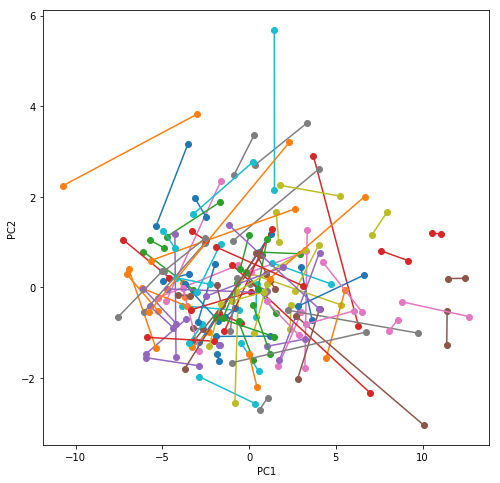

MEAN DISTANCE: 2.5397026452593154


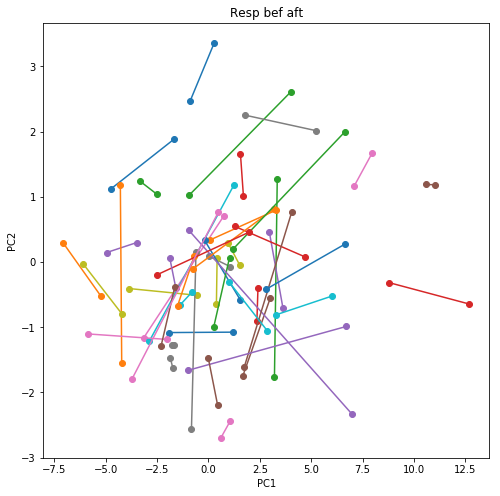

MEAN DISTANCE: 3.0466456121724597


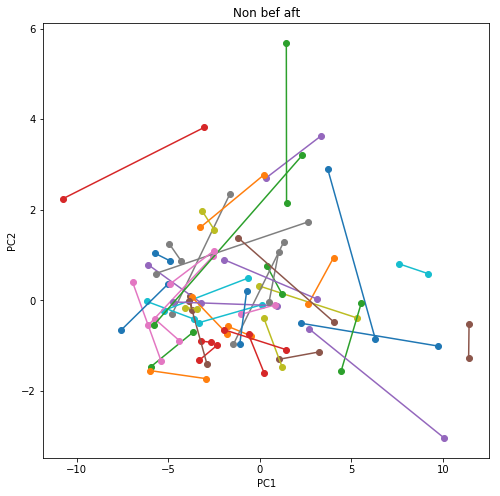

In [34]:
# Plot PCA, but same people with the same color

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn import decomposition
from sklearn import datasets
from math import sqrt

def plot_pca_pairs_2d(df_first, df_second, title=""):
    pca = decomposition.PCA(n_components=2)
    # pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    pca.fit(df[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    fig = plt.figure(figsize=(8,8))
    
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    dists = []
    cmap = plt.get_cmap('gnuplot')
    for i in range(min(len(first), len(second))):
        xs = [first[i, 0], second[i, 0]]
        ys = [first[i, 1], second[i, 1]]
        dists.append(sqrt((first[i,0]-second[i,0])**2 + (first[i,1]-second[i,1])**2))
        # plt.plot(xs, ys, 'o-', color=cmap())
        plt.plot(xs, ys, 'o-')
    print("MEAN DISTANCE: {}".format(sum(dists)/len(dists)))
        
    plt.title(title)
    plt.show()

col = 'lyap'
df, df_bef, df_aft = prepare_dfs(col)
df_resp, df_non = prepare_resp_non(col)

plot_pca_pairs_2d(df_bef, df_aft, title="")
plot_pca_pairs_2d(df_resp.loc[(slice(None), 'a'), :], df_resp.loc[(slice(None), 'b'), :], title='Resp bef aft')
plot_pca_pairs_2d(df_non.loc[(slice(None), 'a'), :], df_non.loc[(slice(None), 'b'), :], title='Non bef aft')

In [21]:
# For each person, plot their distance between before / after
from math import sqrt

def filter_by_distance(df_first, df_second, n_components=3):
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(df_first.append(df_second)[CHANNEL_NAMES])
    first = pca.transform(df_first[CHANNEL_NAMES])
    second = pca.transform(df_second[CHANNEL_NAMES]) if df_second is not None else None
    dists = []
    for fr, sr in zip(first, second):
        dists.append(sqrt(sum([(f-s)**2 for f, s in zip(fr, sr)])))
    perc = np.percentile(dists, 90)
    df = pd.DataFrame()
    for i, (fr, sr) in enumerate(zip(first, second)):
        dist = sqrt(sum([(f-s)**2 for f, s in zip(fr, sr)]))
        if dist > perc:
            df = df.append(df_first.iloc[i, :]) 
    print(df.loc[:, ['resp', 'age', 'sex', 'sc_bef', 'sc_aft', 'change']])
    

col = 'lyap'
df, df_bef, df_aft = prepare_dfs(col)
df_resp, df_non = prepare_resp_non(col)

filter_by_distance(df_bef, df_aft)
filter_by_distance(df_resp.loc[(slice(None), 'a'), :], df_resp.loc[(slice(None), 'b'), :])
filter_by_distance(df_non.loc[(slice(None), 'a'), :], df_non.loc[(slice(None), 'b'), :])

     resp   age  sex  sc_bef  sc_aft    change
1     1.0  49.0  0.0    26.0    13.0  2.000000
20    1.0  49.0  0.0    27.0    13.0  2.076923
28    1.0  57.0  1.0    34.0    10.0  3.400000
62    1.0  34.0  0.0    23.0    10.0  2.300000
72    0.0  55.0  0.0    23.0    18.0  1.277778
102   1.0  56.0  1.0    18.0     6.0  3.000000
114   1.0  55.0  0.0    25.0    12.0  2.083333
123   0.0  54.0  1.0    24.0    25.0  0.960000
124   0.0  52.0  0.0    30.0    23.0  1.304348
127   0.0  35.0  0.0    25.0    21.0  1.190476
129   1.0  38.0  0.0    27.0     6.0  4.500000
          resp   age  sex  sc_bef  sc_aft    change
(62, a)    1.0  34.0  0.0    23.0    10.0  2.300000
(102, a)   1.0  56.0  1.0    18.0     6.0  3.000000
(114, a)   1.0  55.0  0.0    25.0    12.0  2.083333
(129, a)   1.0  38.0  0.0    27.0     6.0  4.500000
          resp   age  sex  sc_bef  sc_aft    change
(72, a)    0.0  55.0  0.0    23.0    18.0  1.277778
(123, a)   0.0  54.0  1.0    24.0    25.0  0.960000
(124, a)   0.0  52.0